# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [1]:
# Имрортируем необходимые библиотеки

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [8]:
df = pd.read_csv('train_data/orange_small_churn_data.txt')

with open('train_data/orange_small_churn_labels.txt', 'r') as fin:
    df['churn'] = list(map(lambda s: int(s.strip()), fin.readlines()))

# (Optional) Write to the file
# df.to_csv(path_or_buf='train_data/churn_train_data.csv',index=False)

In [2]:
# (Optional) Read from the file
df = pd.read_csv('train_data/churn_train_data.csv')

In [3]:
# Split columns

num_features = df.columns[:190]
cat_features = df.columns[190:-1]

In [4]:
# Clear data
df = df.dropna(axis=0, how='all', subset=df.columns[:-1])
df = df.dropna(axis=1, how='all')
df['churn'] = df.churn.apply(lambda x: int(x > 0))

num_features = num_features.intersection(df.columns)
cat_features = cat_features.intersection(df.columns)

2\. Рассчитайте доли классов `отток` и `не отток`.

In [5]:
df.churn.value_counts() / len(df)

0    0.9256
1    0.0744
Name: churn, dtype: float64

Можно видеть, что выборка очень несбалансированная: имеется более чем *92%* пользователей, принадлежащих классу `не отток`, и лишь оставшиеся порядка *7%* - пользователи интересующего нас класса `отток`.

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

In [6]:
# Функции для расчета корреляций

def num_features_binary_target_corr():
    """
    An empirical rule E(X1|X2 = 1) - E(X1|X2 = 0) is used
    """
    for f_name in num_features:
        corr_v = df[f_name][df.churn == 1].mean() - df[f_name][df.churn == 0].mean()
        yield f_name, corr_v
        

def cat_features_binary_target_corr():
    """
    Cramer's V coefficient is used
    """
    for f_name in cat_features:
        confusion_mx = pd.crosstab(df[f_name], df.churn)
        n = confusion_mx.sum().sum()
        phi2 = ss.chi2_contingency(confusion_mx)[0] / n
        r, k = confusion_mx.shape
        phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
        rcorr = r-((r-1)**2)/(n-1)
        kcorr = k-((k-1)**2)/(n-1)
        yield f_name, np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [7]:
# Расчет величин корреляций с целевой переменной
num_corrs = pd.DataFrame.from_dict(dict(num_features_binary_target_corr()), orient='index', columns=['correlation'])
cat_corrs = pd.DataFrame.from_dict(dict(cat_features_binary_target_corr()), orient='index', columns=['correlation'])

In [8]:
# Топ-5 коррелированных вещественных признаков
num_corrs.apply(np.abs).sort_values(by='correlation', ascending=False).head()

,correlation
Var131,1.034608e+07
Var69,4.808584e+05
Var53,4.389077e+05
Var177,4.017487e+05
Var180,3.201630e+05


Как видно, среди вещественных признаков есть те, которые можно интерпретировать как коррелирующие с целевой переменной.

In [9]:
# Топ-5 коррелированных категориальных признаков
cat_corrs.sort_values(by='correlation', ascending=False).head()

,correlation
Var199,0.237375
Var192,0.116264
Var216,0.083442
Var206,0.077436
Var212,0.075150


В отличие от вещественных, среди категориальных признаков не наблюдается значимой корреляции с целевой переменной

4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [98]:
# Function for more flexible visualization
import itertools


def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


def plot_hist(data, n_columns):
    m = int(np.ceil(len(data.columns) / n_columns))
    fig, axs = plt.subplots(m, n_columns, figsize=(6*n_columns, 6*m), constrained_layout=True)
    axs = trim_axs(axs, len(data.columns))
    
    for ax, col in zip(axs, data.columns):
        for i in range(0, 2):
            tmp = data[col][df.churn == i].dropna()
            if not tmp.empty:
                sns.distplot(tmp, ax=ax)

                    
def plot_pairs(data, n_columns):
    # filter pairs without intersections to reduce a number of plots
    pairs = list(itertools.combinations(data.columns.values, 2))
    pairs = [p for p in pairs if not data[[p[0], p[1]]].dropna().empty]
    
    m = int(np.ceil(len(pairs) / n_columns))
    
    fig, axs = plt.subplots(m, n_columns, figsize=(6*n_columns, 6*m), constrained_layout=True)
    axs = trim_axs(axs, len(pairs))
    
    for ax, clms in zip(axs, pairs):
        sns.scatterplot(x=clms[0], y=clms[1], data=data, hue=df.churn, ax=ax)
        

def plot_bars(data, n_columns):
    m = int(np.ceil(len(data.columns[:-1]) / n_columns))
    fig, axs = plt.subplots(m, n_columns, figsize=(6*n_columns, 6*m), constrained_layout=True)
    axs = trim_axs(axs, len(data.columns[:-1]))
    
    for ax, col in zip(axs, data.columns[:-1]):
        cpt = sns.countplot(x=col, hue='churn', data=data, ax=ax)
        cpt.set_xticklabels(cpt.get_xticklabels(), rotation=60)

Для начала взглянем на сами переменные:

In [30]:
top_20 = num_corrs.apply(np.abs).sort_values(by='correlation', ascending=False).index[:20]
df[top_20].describe().T

,count,mean,std,min,25%,50%,75%,max
Var131,570.0,4.159484e+06,2.584101e+07,0.0,0.0,0.000,0.00,442233600.0
Var69,1165.0,3.538868e+06,4.942787e+06,0.0,0.0,432972.000,6376329.00,18741870.0
Var53,570.0,6.486416e+05,1.334177e+06,0.0,0.0,89244.000,713601.00,12513150.0
Var177,1006.0,6.252132e+05,1.321047e+06,0.0,0.0,0.000,554412.25,8554350.0
Var180,570.0,3.823922e+06,3.762206e+06,0.0,272135.5,2423981.000,6593977.25,14284830.0
Var114,1006.0,6.116184e+05,9.332979e+05,0.0,0.0,7021.000,974294.50,4267360.0
Var111,890.0,2.960736e+05,5.264826e+05,0.0,0.0,94314.305,390408.00,3628806.0
Var113,40000.0,-1.542483e+05,7.615541e+05,-9803600.0,-184762.7,29327.940,147005.80,9932480.0
Var153,35984.0,6.186849e+06,4.347667e+06,0.0,1237981.0,8138440.000,10376120.00,13907800.0
Var154,570.0,1.602314e+06,2.338722e+06,0.0,0.0,369308.000,2334524.00,15048560.0


Видно, что распределение некоторых переменных сильно скошено, а разброс значений довольно велик. Для наглядности нормируем значения, чтобы уменьшить масштаб:

In [32]:
norm_top_20 = df[top_20]
norm_top_20 = (norm_top_20 - norm_top_20.min()) / (norm_top_20.max() - norm_top_20.min())

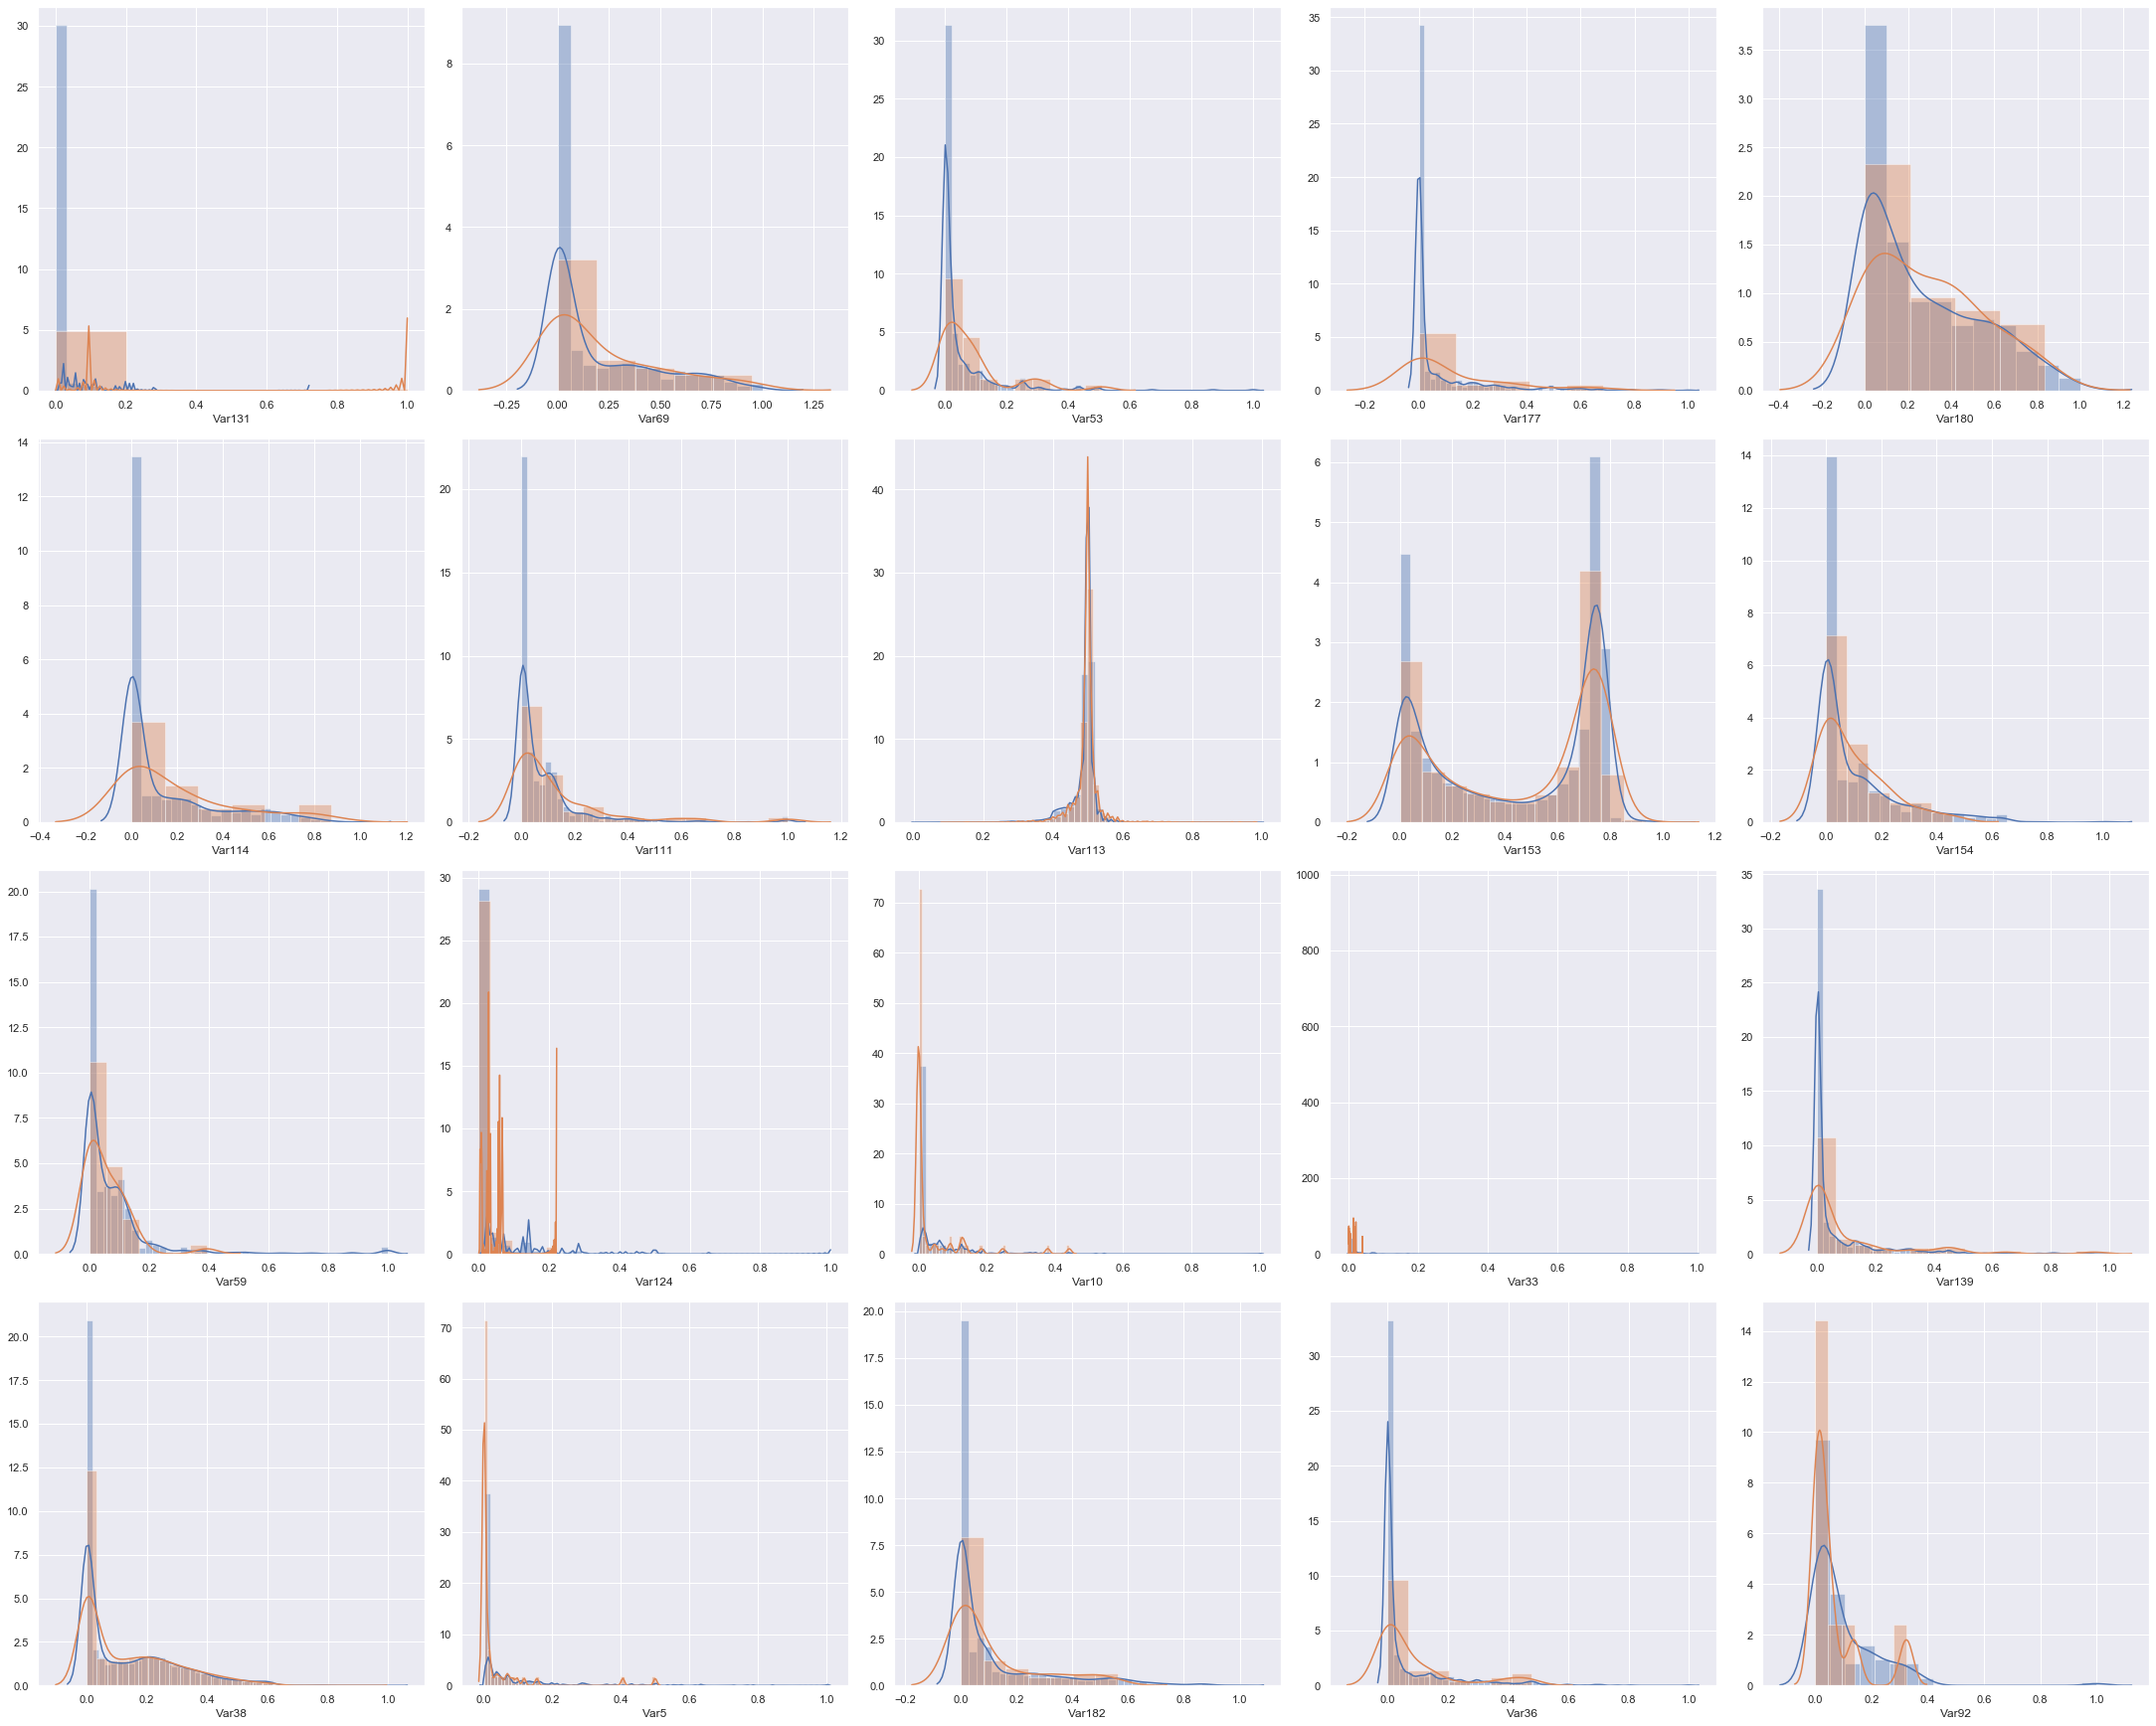

In [35]:
# Вывод гистограмм распределения признаков
plot_hist(norm_top_20, 5)

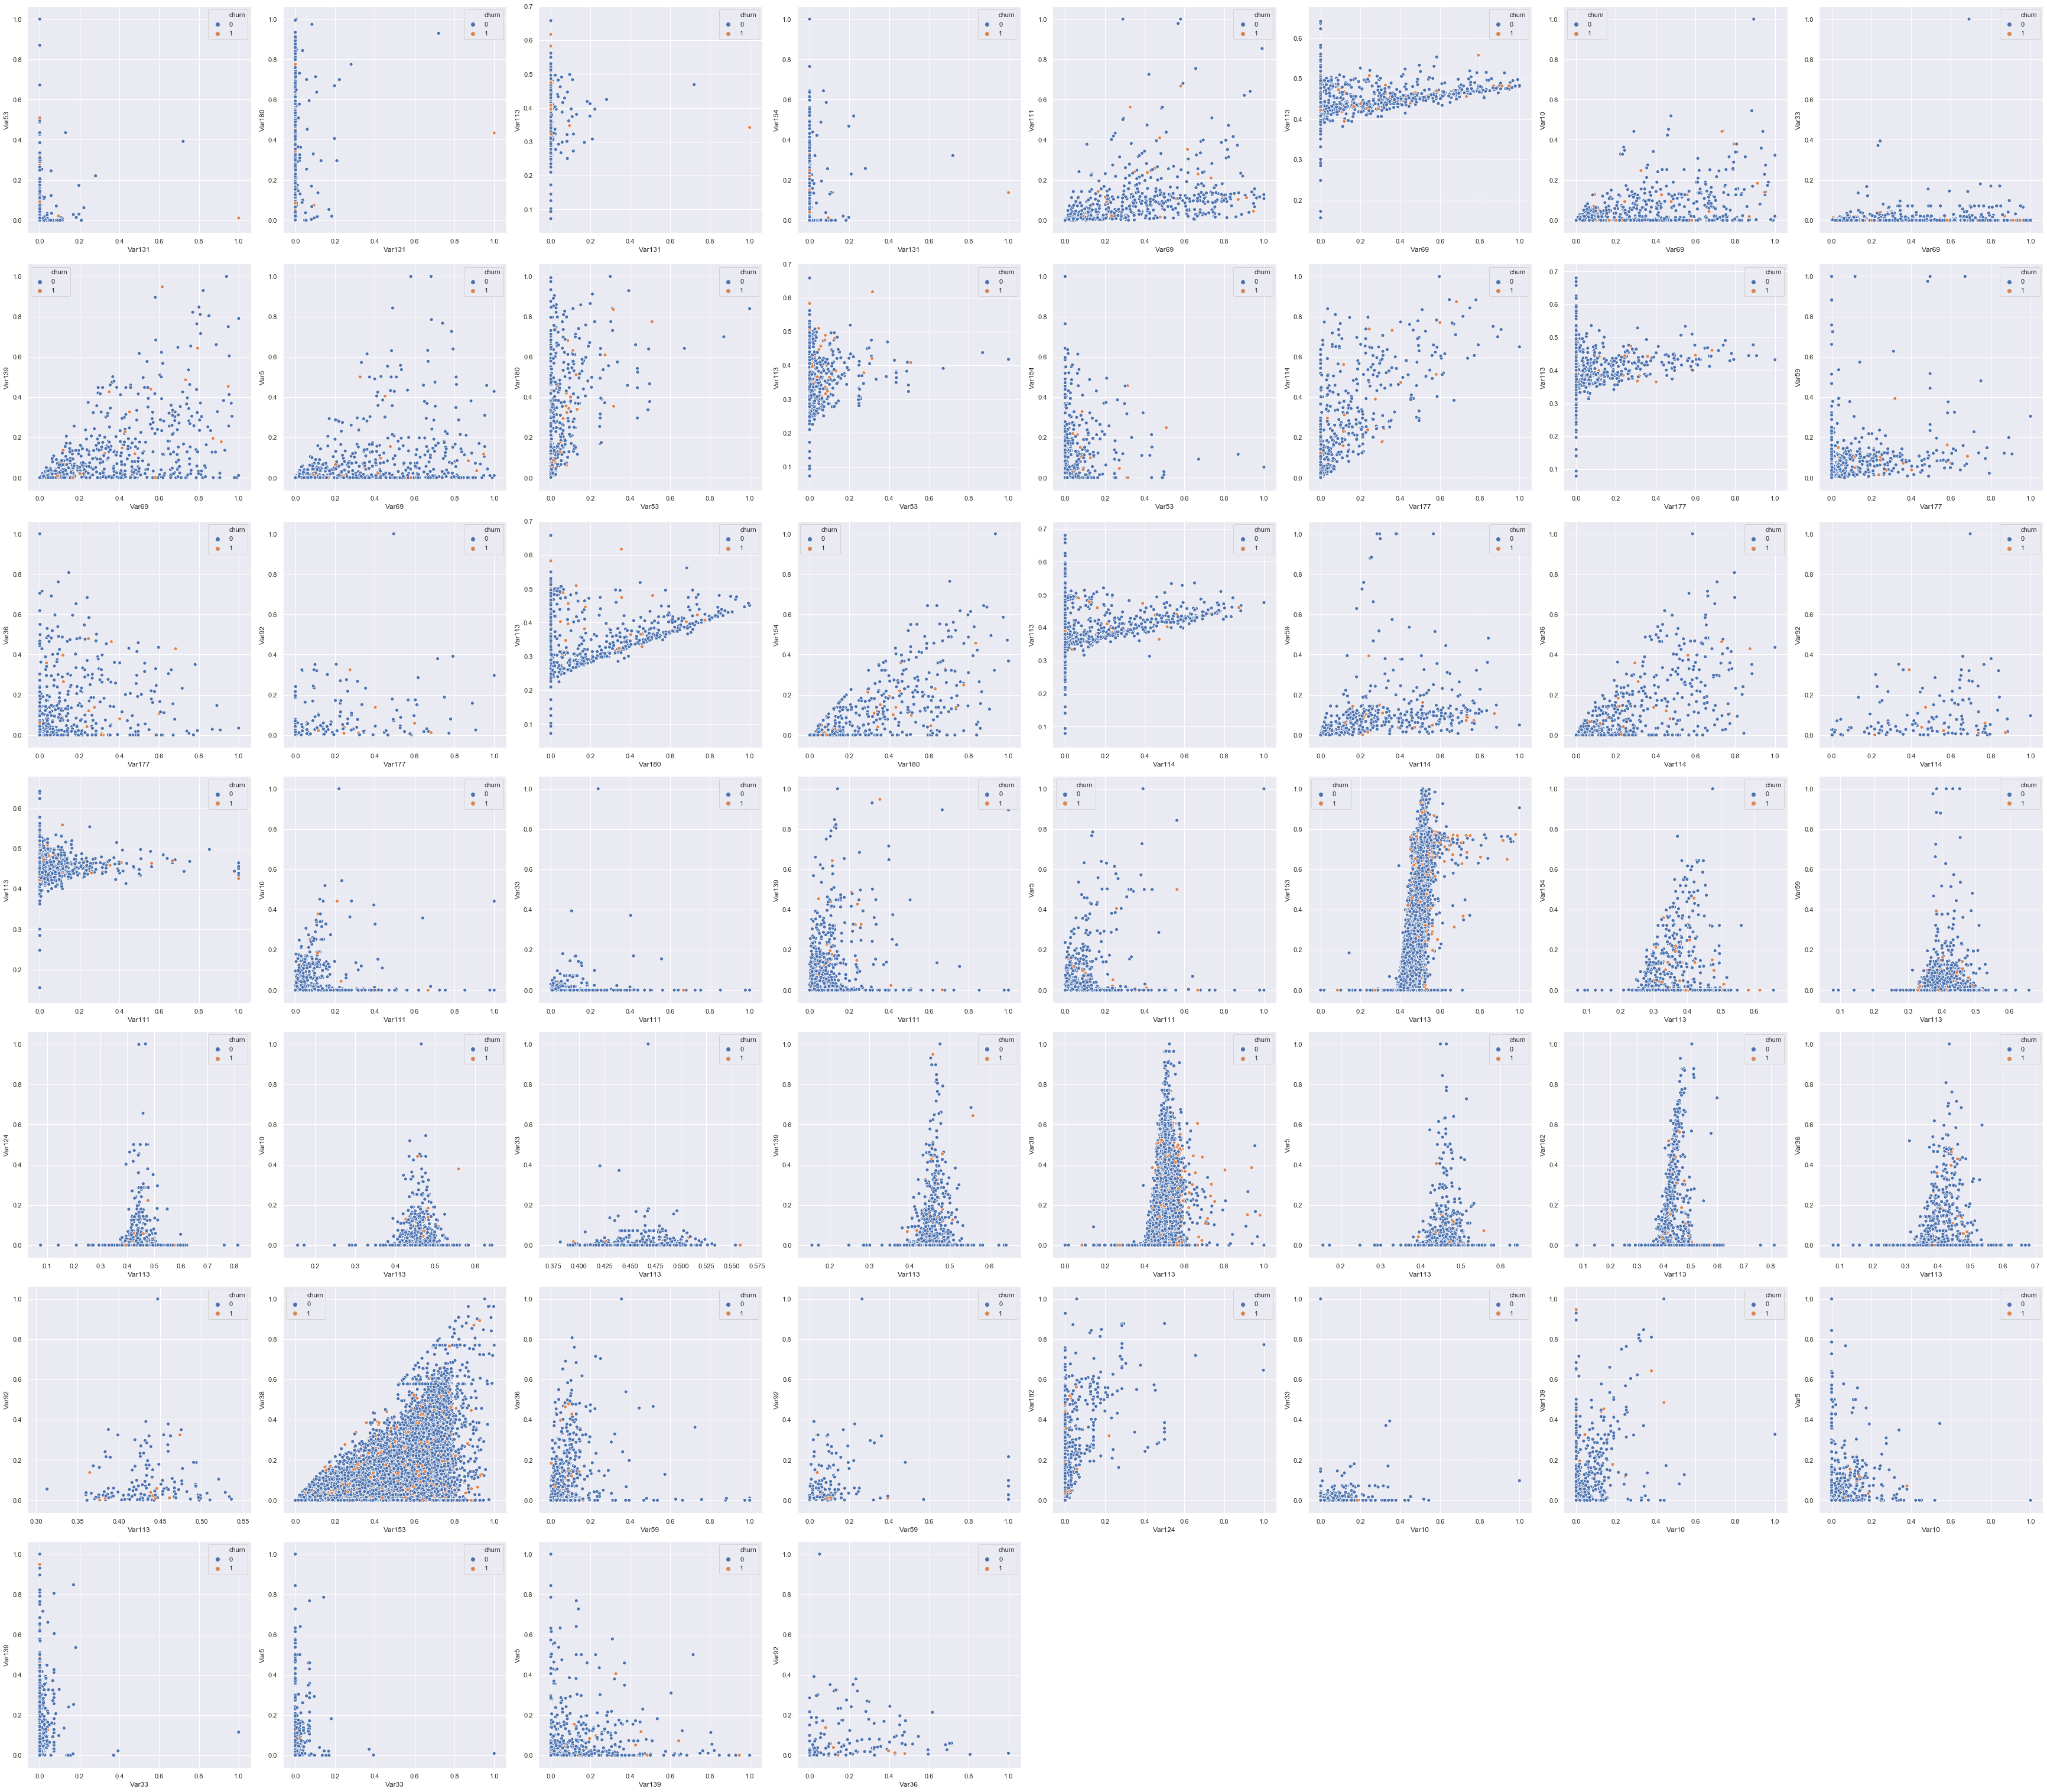

In [36]:
# Вывод попарных сравнений признаков
plot_pairs(norm_top_20, 8)

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

Выберем 10 случайных величин, не входящих в число 20 наиболее коррелированных и 10 наименее коррелированных вещественных признаков и проанализируем их:

In [37]:
middle_earth = num_corrs.apply(np.abs).sort_values(by='correlation', ascending=False).index[20:-10].values
np.random.seed(42)
np.random.shuffle(middle_earth)

sample_10 = middle_earth[:10]
df[sample_10].describe().T

,count,mean,std,min,25%,50%,75%,max
Var121,570.0,6.989474,31.287822,0.00,0.00,2.00,6.0,672.00
Var58,570.0,172511.115789,674633.500013,0.00,0.00,0.00,71394.0,9676800.00
Var89,524.0,5.198473,13.538089,0.00,0.00,0.00,6.0,138.00
Var152,1275.0,8.400000,9.002354,0.00,0.00,6.00,12.0,66.00
Var66,563.0,95.474245,296.017133,0.00,8.00,40.00,92.0,4600.00
Var134,35984.0,438029.794687,605850.262835,0.00,29268.00,209196.00,616848.0,5735340.00
Var35,35984.0,0.710038,2.941115,0.00,0.00,0.00,0.0,60.00
Var9,570.0,47.487719,147.137816,0.00,4.00,20.00,46.0,2300.00
Var28,35983.0,224.303641,97.958424,-66.88,166.56,220.08,266.4,5158.56
Var94,22063.0,98067.049087,172727.493728,0.00,8508.00,41031.00,117985.5,3869280.00


Как и в предыдущем случае видно, что распределение некоторых переменных сильно скошено, а разброс значений довольно велик. Для наглядности нормируем значения, чтобы уменьшить масштаб:

In [38]:
norm_sample_10 = df[sample_10]
norm_sample_10 = (norm_sample_10 - norm_sample_10.min()) / (norm_sample_10.max() - norm_sample_10.min())

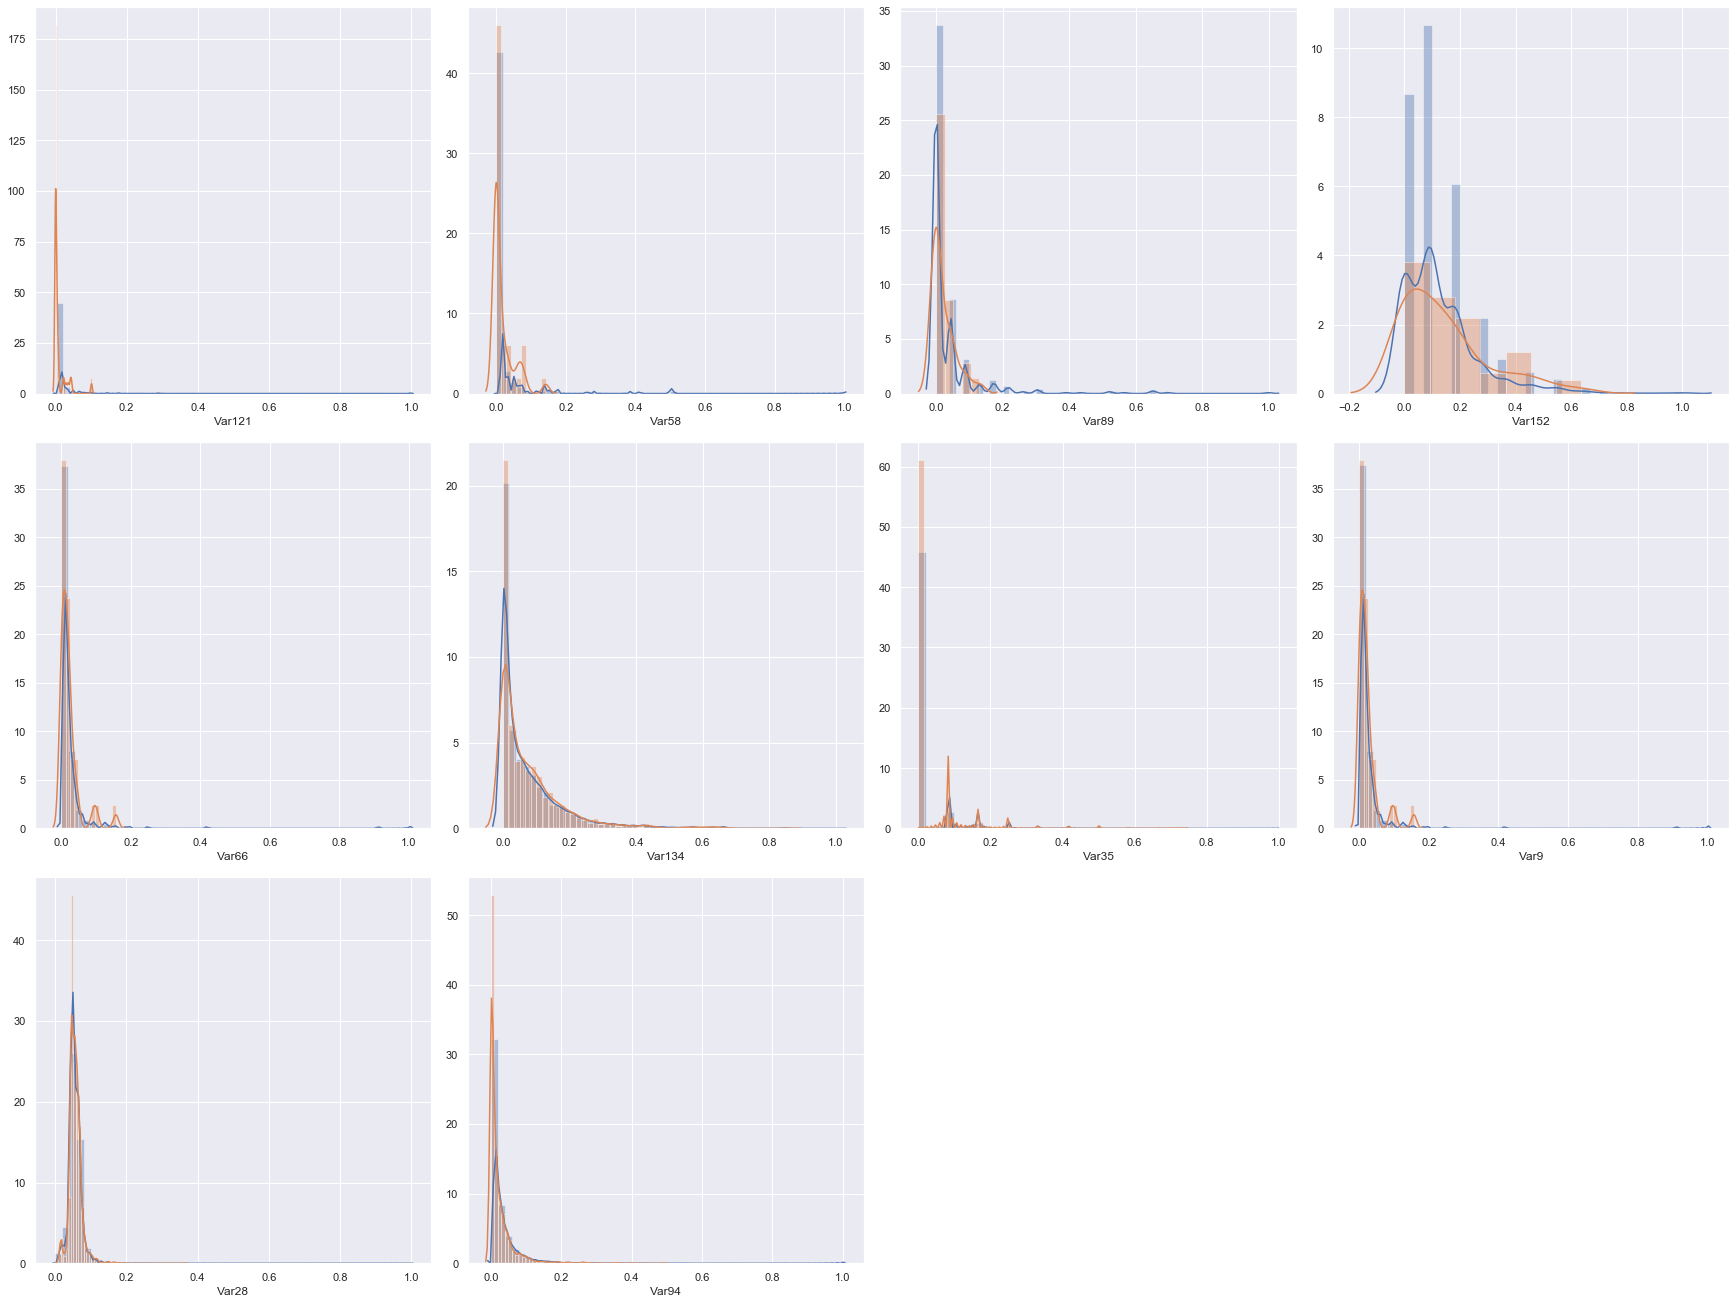

In [39]:
# Вывод гистограмм распределения признаков
plot_hist(norm_sample_10, 4)

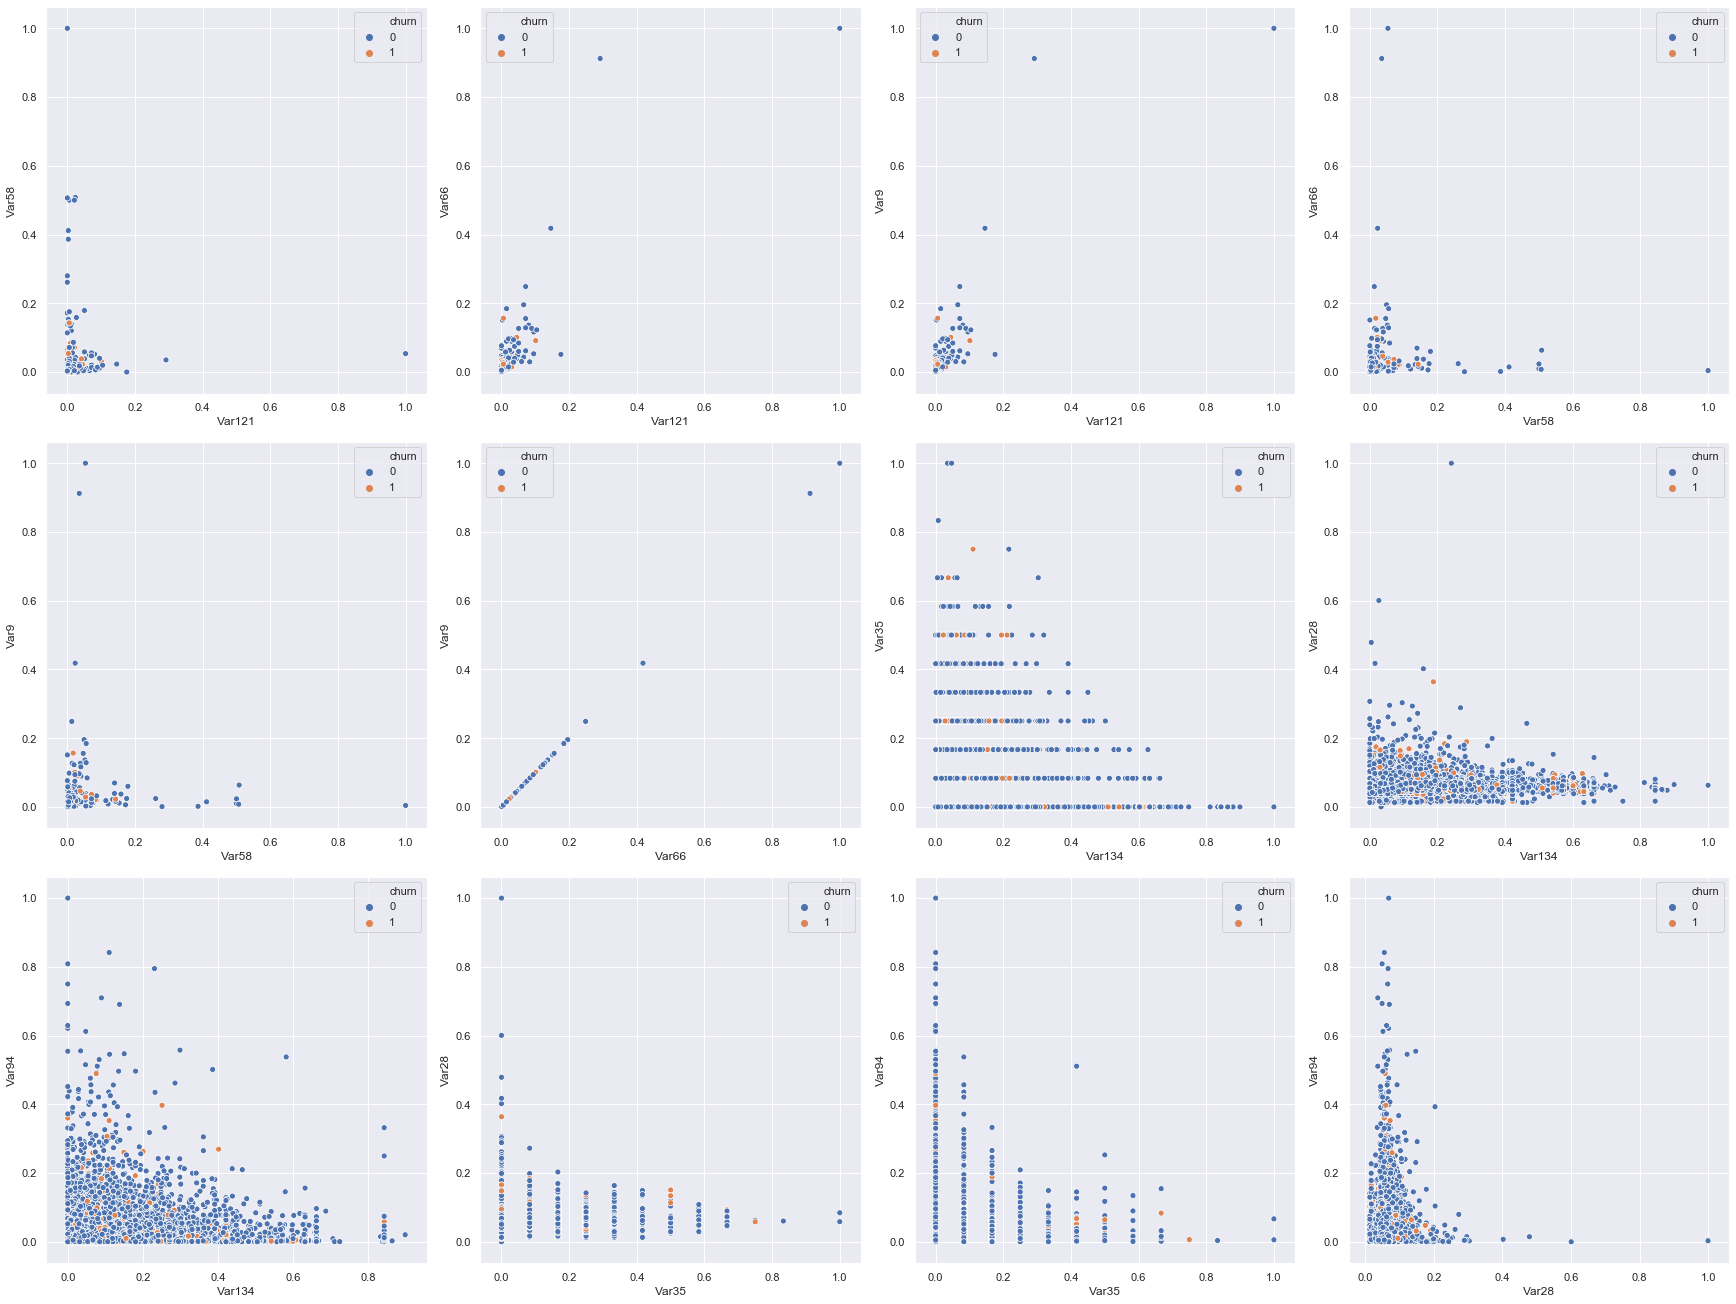

In [40]:
# Вывод попарных сравнений признаков
plot_pairs(norm_sample_10, 4)

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

Выберем 10 наименее коррелированных вещественных признаков и проанализируем их:

In [41]:
bottom_10 = num_corrs.apply(np.abs).sort_values(by='correlation', ascending=True).index[:10]

df[bottom_10].describe().T

,count,mean,std,min,25%,50%,75%,max
Var118,140.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
Var138,1275.0,0.001569,0.056011,0.0,0.0,0.0,0.0,2.0
Var44,35984.0,0.167574,1.659588,0.0,0.0,0.0,0.0,135.0
Var173,35984.0,0.006781,0.132355,0.0,0.0,0.0,0.0,6.0
Var2,1006.0,0.004970,0.157642,0.0,0.0,0.0,0.0,5.0
Var116,570.0,0.073684,0.464760,0.0,0.0,0.0,0.0,3.0
Var4,1275.0,0.148235,1.396054,0.0,0.0,0.0,0.0,27.0
Var26,1165.0,0.069528,0.530325,0.0,0.0,0.0,0.0,9.0
Var29,570.0,0.017544,0.186658,0.0,0.0,0.0,0.0,2.0
Var181,35984.0,0.610633,2.492228,0.0,0.0,0.0,0.0,49.0


Как можно видеть, распределение большинства из этих 10 признаков сильно скошено, а признак `Var118` имеет константное значение. Посмотрим на графики:

In [42]:
norm_bottom_10 = df[bottom_10]
norm_bottom_10 = (norm_bottom_10 - norm_bottom_10.min()) / (norm_bottom_10.max() - norm_bottom_10.min())

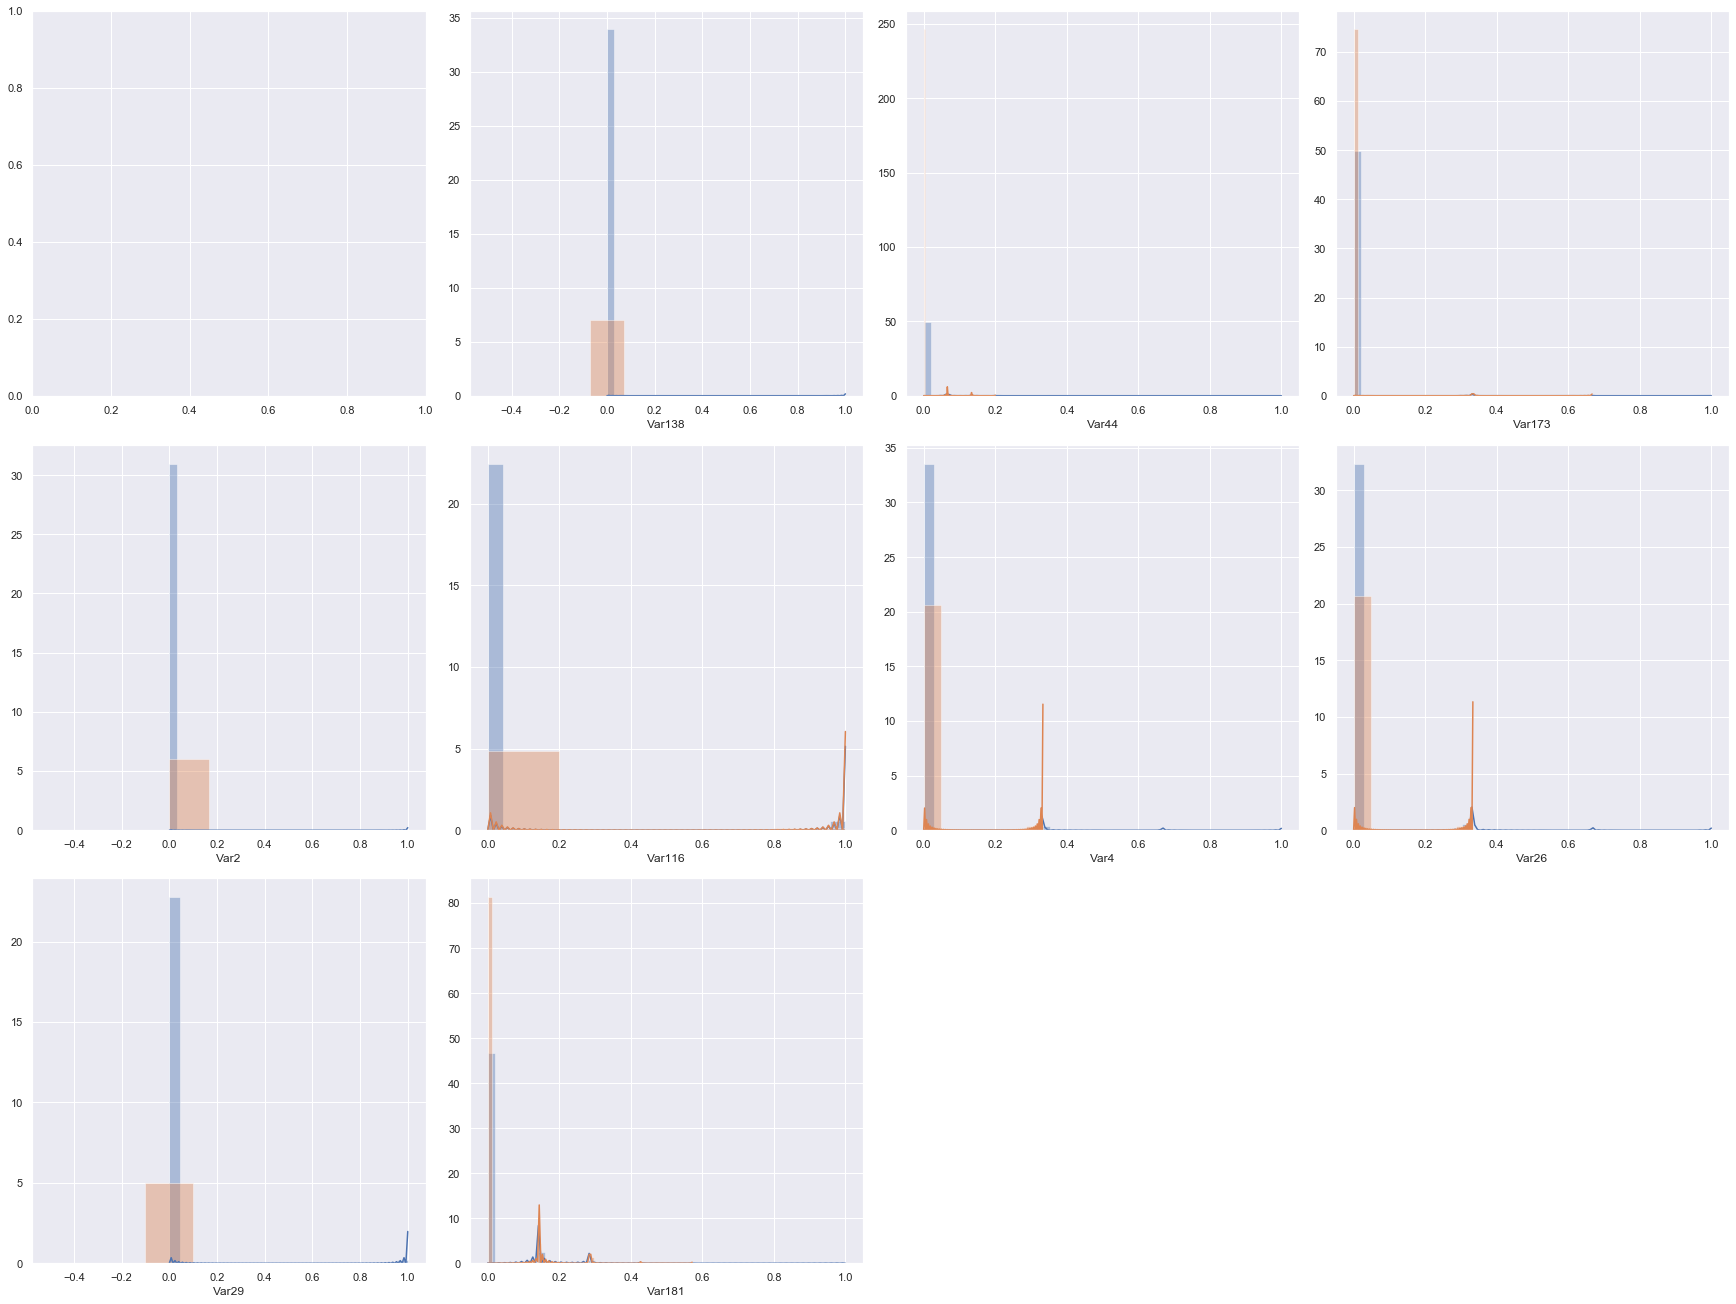

In [43]:
# Вывод гистограмм распределения признаков
plot_hist(norm_bottom_10, 4)

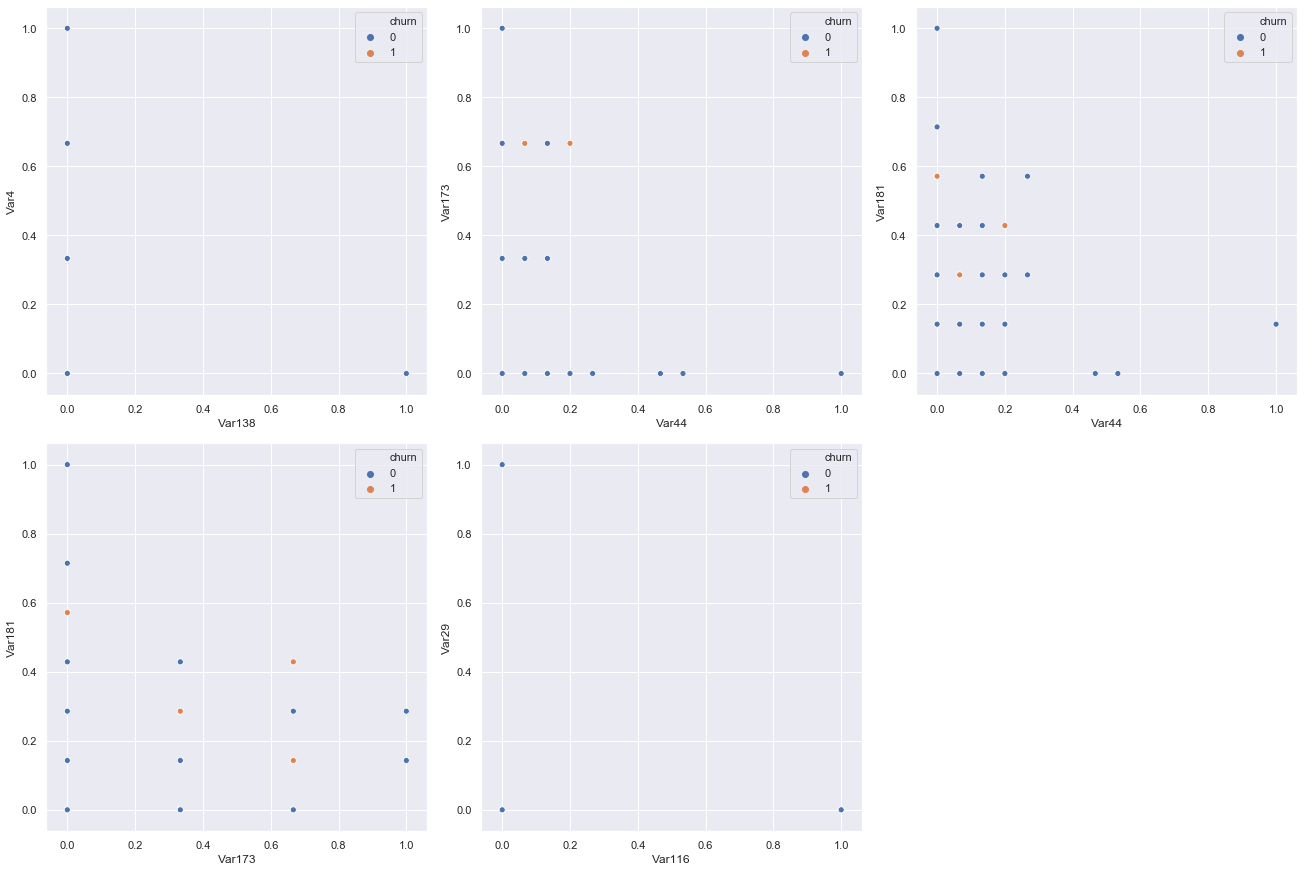

In [44]:
# Вывод попарных сравнений признаков
plot_pairs(norm_bottom_10, 3)

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

Прежде чем строить гистограммы для категориальных признаков, посмотрим на сами категории (их кол-во может быть довольно большим):

In [111]:
df[cat_features].describe().T

,count,unique,top,freq
Var191,871,1,r__I,871
Var192,39709,354,1GdOj1KXzC,313
Var193,40000,50,RO12,28817
Var194,10190,3,SEuy,10015
Var195,40000,23,taul,38353
Var196,40000,4,1K8T,39633
Var197,39877,220,0Xwj,3688
Var198,40000,3891,fhk21Ss,3557
Var199,39996,4400,r83_sZi,746
Var200,19634,13297,yP09M03,51


In [112]:
num_cats = {
    col:[
        len(df[col].dropna().unique()),
        len(df[col].dropna()) / len(df[col].dropna().unique())
    ] for col in cat_features
}
num_cats = pd.DataFrame.from_dict(num_cats, orient='index', columns=['num_categories', 'mean_density'])

num_cats.describe(percentiles=[.25, .50, .60, .70, .80, .95])

,num_categories,mean_density
count,38.000000,38.000000
mean,1670.815789,4018.618165
std,3683.554958,5723.030355
min,1.000000,1.476574
25%,3.000000,129.444010
50%,17.500000,1480.393939
60%,24.400000,1962.732919
70%,97.800000,5016.075000
80%,3062.200000,6542.000000
95%,12594.050000,19752.775000


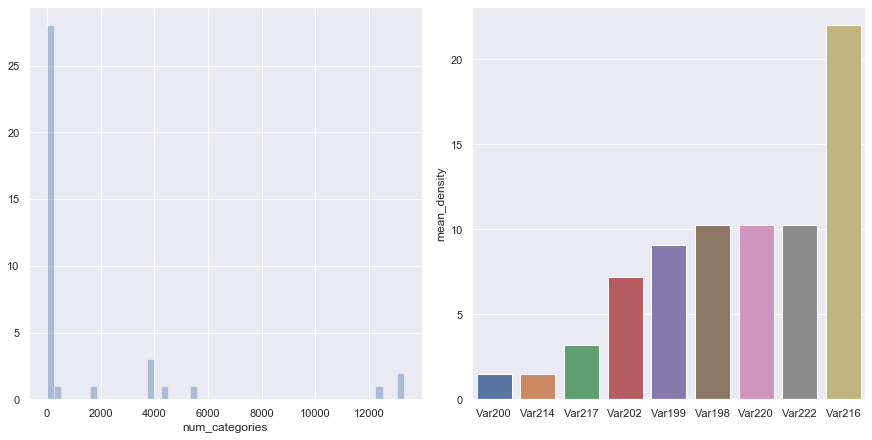

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
sns.distplot(num_cats.num_categories, bins=50, kde=False, ax=ax[0])

small_mean_density = num_cats[num_cats.mean_density < 50].sort_values(by='mean_density')

sns.barplot(x=small_mean_density.index.values, y=small_mean_density.mean_density, ax=ax[1])

Видно, что у примерно 40 % вещественных признаков число возможных категорий больше 25, а у примерно 20 % число категорий достигает нескольких тысяч, что банально неудобно для непосредственного визуального анализа. Кроме того, у некоторых вещественных признаков среднее кол-во примеров в датасете на категорию пренебрежимо мало. Посмотрим, что это за признаки:

In [87]:
for ft, cats in zip(small_mean_density.index.values, small_mean_density.num_categories):
    print(f"{ft}: {cats} categories. Sample: {df[ft].dropna().sample(5).values}")

Var200: 13297 categories. Sample: ['IvrsNPq' 'mVr4aAy' '90nTH18' 'wmszuh6' 'k859q9H']
Var214: 13297 categories. Sample: ['6ZDe_LA' 'Cmibgcr' '9IGGtvB' '8sa3wFb' '9rV3O8k']
Var217: 12470 categories. Sample: ['FaHP' 'cfcS' 'eiOI' '9nGL' 'xqzj']
Var202: 5542 categories. Sample: ['73bX' 'Y_20' 'X3ZN' 'LQtK' '13zP']
Var199: 4400 categories. Sample: ['IoHCTe99VL' 'itSGh3t' 'e1XhvTunuD' '25RRhwb' 'WN2wUb0T0UKRa']
Var198: 3891 categories. Sample: ['0Vr7wZ4' '3ZjT9kY' 'EQsMhNR' 'Uz6lJRo' 'fhk21Ss']
Var220: 3891 categories. Sample: ['aD1vOIl' '4UxGlow' 'vz9VAr3' '_Mc87dl' 'tHIJiTc']
Var222: 3891 categories. Sample: ['Q53Rkup' 'tFTzAyO' 'o6f7A2G' 'IIoOTZB' 'y1zz20V']
Var216: 1819 categories. Sample: ['mAjbk_S' '7WwOAni' 'kq0n8Bj' '11p4mKe' '11p_E1H']


Для этих признаков характерно большое число уникальных значений. Скорее всего такие признаки не несут в себе полезной информации для решения задачи.

Теперь построим гистограммы для вещественных признаков с небольшим числом категорий:

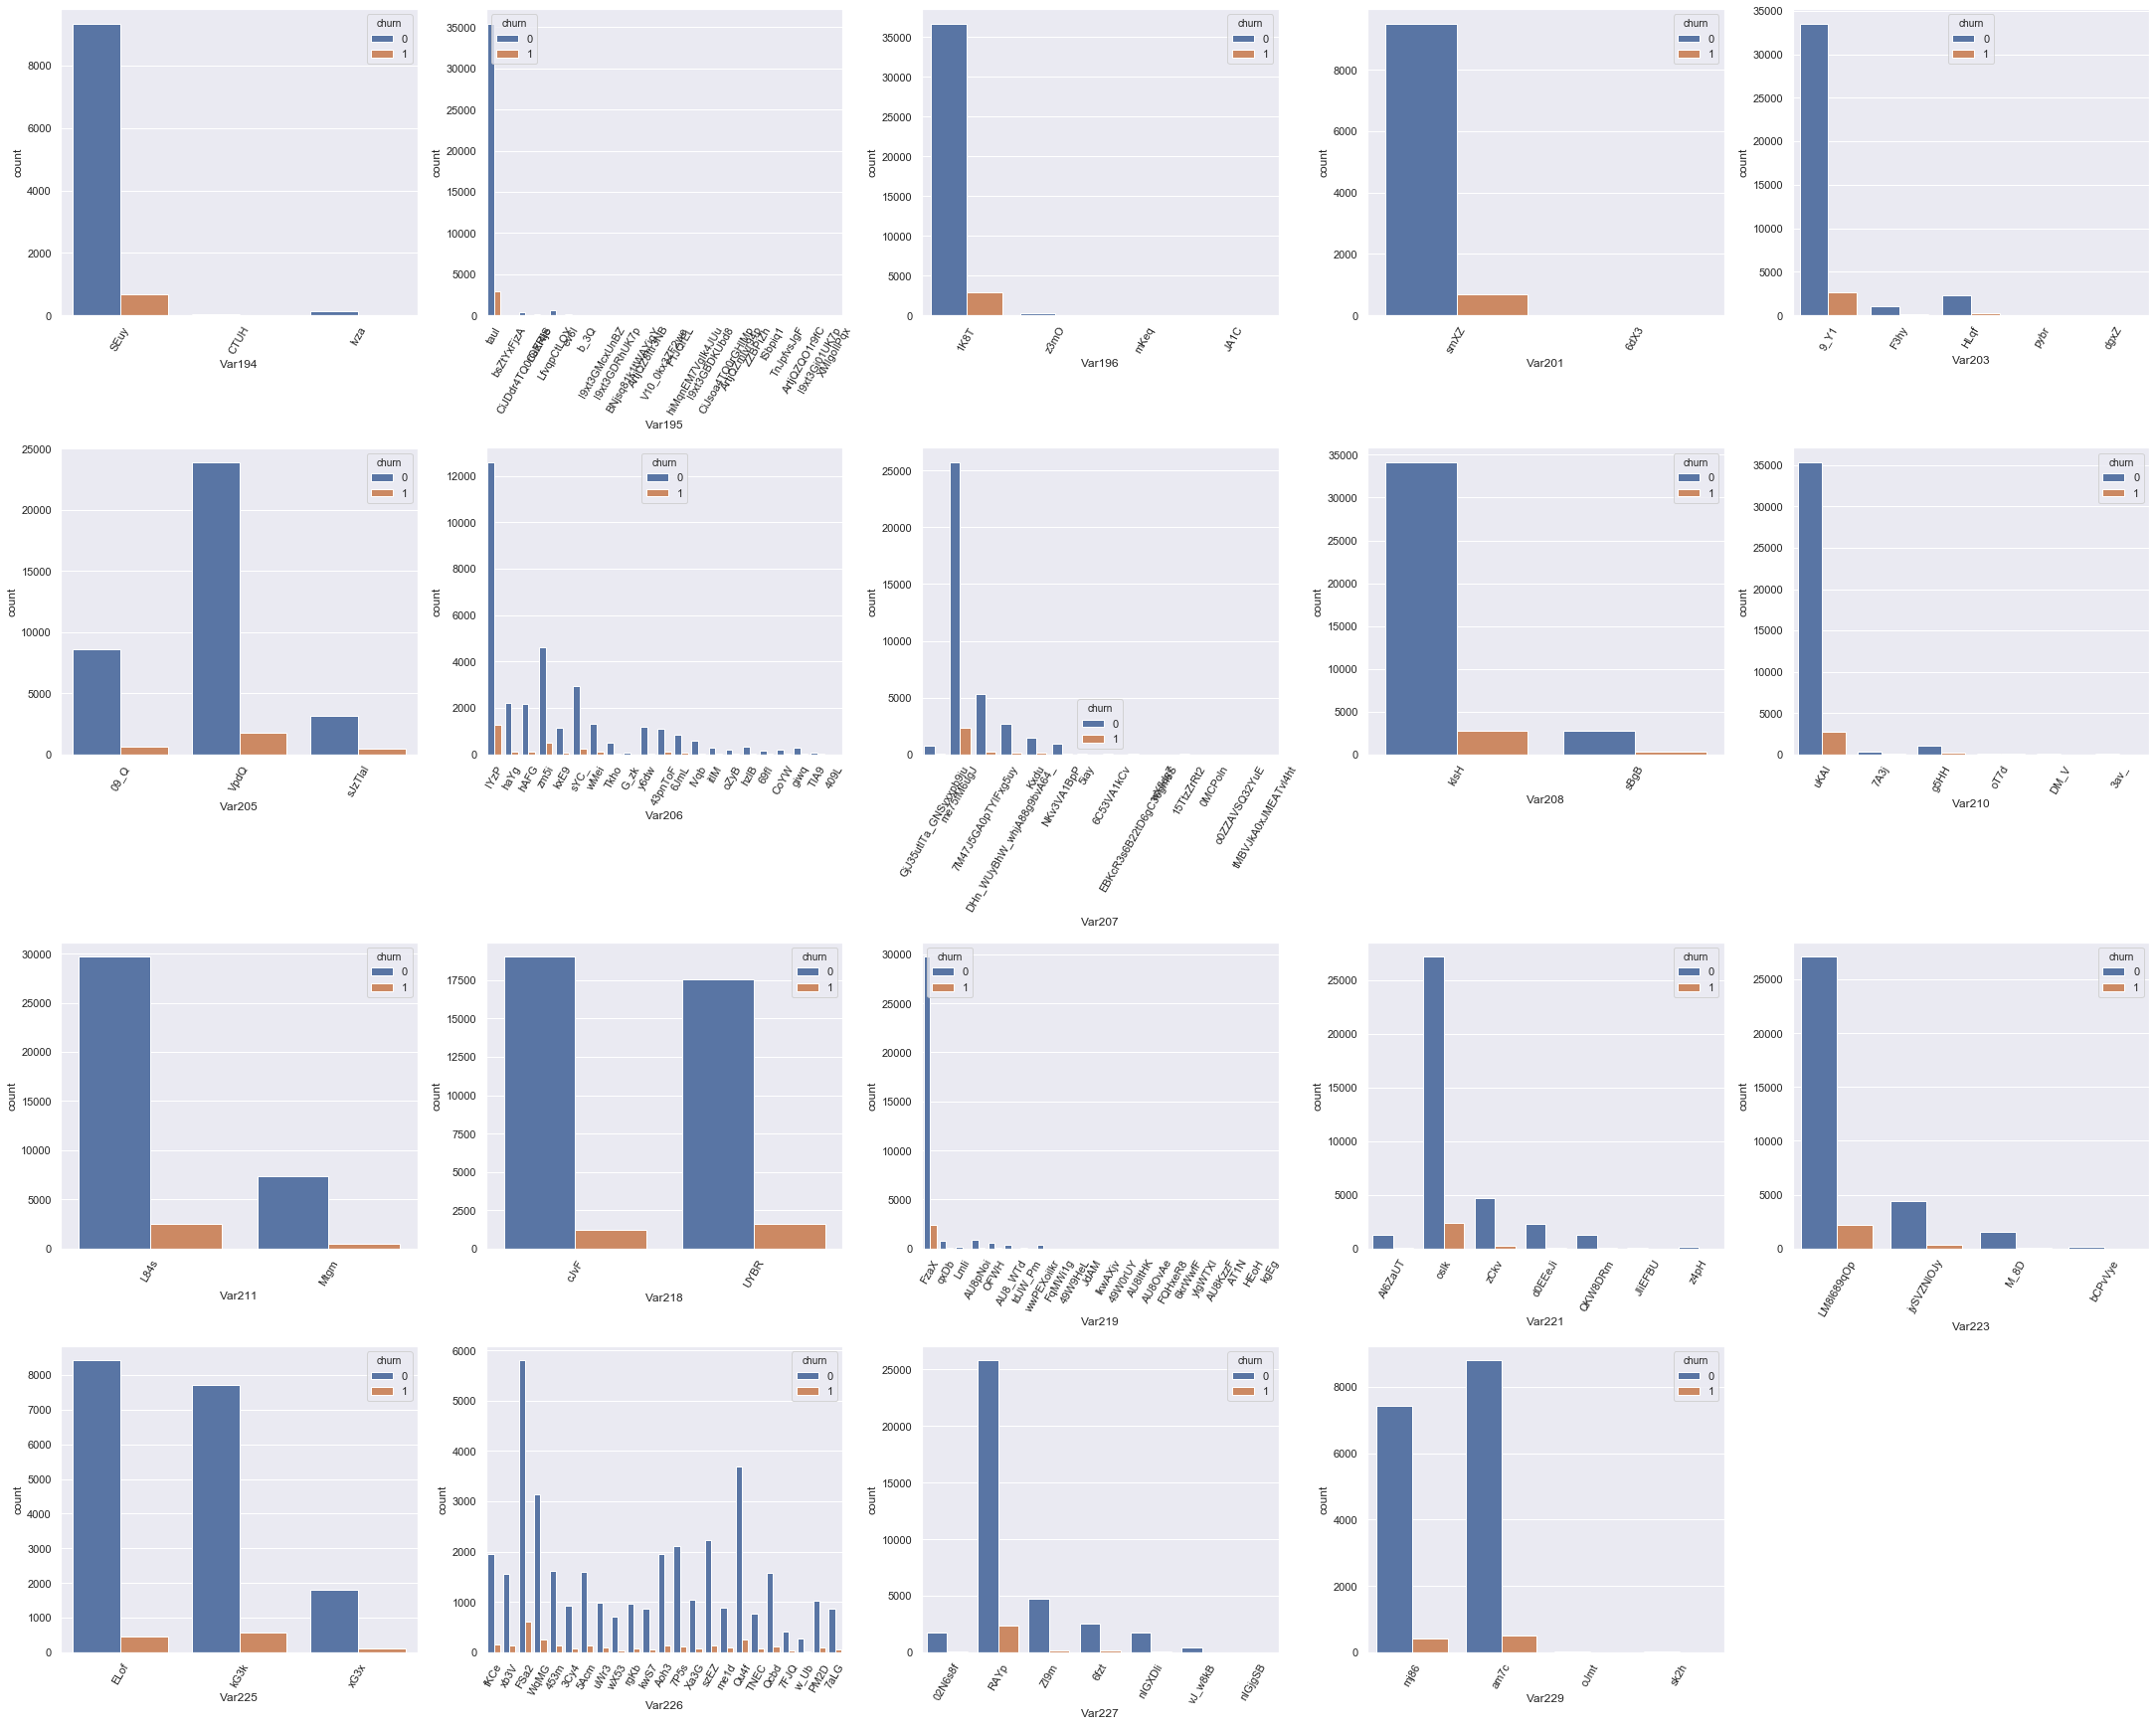

In [108]:
small_cats = num_cats[(num_cats.num_categories > 1) & (num_cats.num_categories < 25)].index.union(['churn'])

plot_bars(df[small_cats], 5)

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

Оригинальный датасет содержит выборку из 40000 пользователей, каждый из которых описан 190 вещественными и 40 категориальными признаками. Выборка несбалансирована, примеров пользователей интересующего нас класса `отток` всего лишь порядка 7 % (примерно 2800 объектов). Выборка содержала некоторое кол-во признаков, значения которых отсутствовали для всех 40000 пользователей. После удаления этих колонок в датасете осталось 174 вещественных и 38 категориальных признаков.<br />

Анализ вещественных признаков выявил следующие особенности:
* Матрица вещественных признаков разрежена, для многих из них характерно отсутствие значений для большинства пользователей.
* Значительное число признаков имеет сильно скошенное распределение (преимущественно в область минимальных значений, зачастую нулевого).
* Многие признаки изменяются в широком диапазоне, что может потребовать нормализации при обучении моделей.
* Некоторые признаки имеют явно дискретное распределение (например *Var35*, *Var173*).
* Некоторые признаки вероятно являются бинарными (например *Var136* и *Var116*). 
* Некоторые признаки являются константами (например *Var118*).
* При сравнении пар можно обнаружить наличие строгой линейной зависимости между некоторыми признаками (например *Var9* и *Var66*).
* Некоторые пары демонстрируют такую тенденцию при ненулевом значении одного из признаков (например пара *Var113* и *Var114* при ненулевом *Var114*).
* В некоторых парах признаки формируют линейные зависмости для некоторых подмножеств (*Var69* и *Var111*).

Среди проанализированных 20 признаков, которые можно интерпретировать как коррелирующие с целевым, интерес представляют признаки *Var131*, *Var124*, *Var10*, *Var33* и *Var5*. Вместе с тем, случайный отбор признаков также показал интересные распределения класса `отток`, например среди признаков *Var121*, *Var58* и *Var35*. Аналогичные наблюдения можно сделать и для гистограмм распределения наименее коррелированных признаков, например  *Var116*, *Var4*, *Var26* и *Var181*. Наименее полезными будут признаки с константными значениями, признаки, линейно зависимые друг от друга (один из них), а также признаки, в которых распределения целевых классов практически идентичны.<br />

Анализ категориальных признаков выявил следующие особенности:
* Многие из признаков также имеют сильно скошенное распределение в сторону определенной категории.
* Примерно для 20 % признаков число уникальных категорий достигает нескольких тысяч. Многие из этих категорий представлены в датасете незначительным кол-вом примеров (часто всего одним).
* Среди категориальных признаков есть константные (например *Var191* и *Var213*).

В целом среди категориальных признаков интерес вероятно представляют признаки с небольшим числом уникальных категорий, в которых целевой признак распределен по категориям неравномерно (например признаки *Var194*, *Var196* и *Var201*). Соответственно, наименее полезными будут признаки с большим числом уникальных категорий и незначительным кол-вом примеров на каждую из них, а также константые признаки.<br />

На основании проведенного анализа можно уверенно сделать вывод о том, что перед обучением моделей необходимо будет провести тщательный отбор и предобработку признаков и, возможно, ввести ряд дополнительных признаков при работе с категориями.